In [1]:
import tensorflow as tf
import numpy as np
from keras import layers, models
import matplotlib.pyplot as plt
from matplotlib import gridspec
from PIL import Image
import csv

In [2]:
# function to create a grayscale copy of an image for training
def make_gray(im):
    grayim = []
    for i in range(len(im)):
        grayim.append([])
        for j in range(len(im[i])):
            average = int(np.average(im[i][j][0:3]))
            if (len(im[i][j]) == 3):
                grayim[-1].append([average,average, average])
            else:
                grayim[-1].append([average,average, average, 255])

    grayim = np.array(grayim)

    return grayim

In [3]:
# create the dataset for training

class_names = np.array(['House', 'Tree'])

ADD_GRAY_IMAGES = True

# Loads the labeled houses and trees
ds = []
labels = []
with open('Dataset.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:

        
        # Find the labeled portion of the image
        x1 = int(row['bbox_x'])
        x2 = int(row['bbox_x']) + int(row['bbox_width'])
        y1 = int(row['bbox_y'])
        y2 = int(row['bbox_y']) + int(row['bbox_height'])
        # trim image to find the correct part for training
        im = np.array(Image.open('Images/' + row['image_name']))[y1:y2, x1:x2, 0:3]
        # resize the image so that it is proper size for our model
        im = np.array(Image.fromarray(im).resize((32,32)))

        # labels need to be integers
        labels.append(np.where(class_names == row['label_name'])[0])
        # append image
        ds.append(im)

        if (ADD_GRAY_IMAGES):
            # add a grayscale of the same image to the dataset
            labels.append(np.where(class_names == row['label_name'])[0])
            ds.append(make_gray(im))

# percent of labels to use for training
training_percent = 0.7
train_labels, test_labels = np.split(labels,[int(training_percent * len(labels))])
train_images, test_images = np.split(ds,[int(training_percent * len(ds))])

train_images, test_images = train_images / 255.0, test_images / 255.0

In [4]:
# Make the model

model = models.Sequential()
model.add(layers.RandomFlip("horizontal_and_vertical"))
model.add(layers.RandomRotation(0.5))
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2))

In [5]:
# Train the model
LR = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, batch_size=10,
                    validation_data=(test_images, test_labels))


Epoch 1/10
46/46 [==============================] - 3s 13ms/step - loss: 0.6578 - accuracy: 0.6863 - val_loss: 0.5526 - val_accuracy: 0.7208
Epoch 2/10
46/46 [==============================] - 0s 10ms/step - loss: 0.3713 - accuracy: 0.8388 - val_loss: 0.1849 - val_accuracy: 0.9442
Epoch 3/10
46/46 [==============================] - 0s 9ms/step - loss: 0.2305 - accuracy: 0.9041 - val_loss: 0.4678 - val_accuracy: 0.8579
Epoch 4/10
46/46 [==============================] - 1s 13ms/step - loss: 0.2059 - accuracy: 0.9325 - val_loss: 0.2365 - val_accuracy: 0.9289
Epoch 5/10
46/46 [==============================] - 1s 13ms/step - loss: 0.2315 - accuracy: 0.9237 - val_loss: 0.1443 - val_accuracy: 0.9340
Epoch 6/10
46/46 [==============================] - 1s 15ms/step - loss: 0.1870 - accuracy: 0.9237 - val_loss: 0.2749 - val_accuracy: 0.8985
Epoch 7/10
46/46 [==============================] - 1s 14ms/step - loss: 0.1921 - accuracy: 0.9281 - val_loss: 0.4413 - val_accuracy: 0.8680
Epoch 8/10
46/

In [6]:
# uses a model to perform object detection on the specified image (file location of image)
def detect(model, location):
    class_names = np.array(['House', 'Tree'])
    gridification = 4
    pixels = int(256 / gridification)

    imArray = np.array(Image.open(location))

    plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(gridification, gridification, width_ratios=[1, 1, 1, 1],
            wspace=0.0, hspace=0.0, top=1.0, bottom=0.0, left=0.0, right=1.0)
    imNum = 1
    result = []
    houses = 0
    trees = 0
    for x in range(gridification):
        result.append([])
        for y in range(gridification):
            chunk = imArray[pixels*x:pixels*(x+1)-1, pixels*y:pixels*(y+1)-1, 0:3]
            ax = plt.subplot(gs[x, y])
            ax.set_aspect("auto")
            imNum = imNum + 1
            plt.imshow(chunk)
            plt.axis("off")
            chunk = np.array(Image.fromarray(chunk).resize((32,32)))
            chunk = chunk / 255.0
            predictions = model.predict(np.array([chunk]),verbose = 0)
            score = tf.nn.softmax(predictions[0])
            if (100 * np.max(score) > 80):
                result[-1].append([class_names[np.argmax(score)], np.max(score) * 100])
                if class_names[np.argmax(score)] == "House":
                    ax.add_patch(plt.Rectangle((0,0), pixels-1.5, pixels-1.5, lw=3, fill=False, color="red"))
                    houses = houses + 1
                elif class_names[np.argmax(score)] == "Tree":
                    ax.add_patch(plt.Rectangle((0,0), pixels-1.5, pixels-1.5, lw=3, fill=False, color="green"))
                    trees = trees + 1
                
            else:
                result[-1].append(['nothing', np.max(score)])

    plt.subplots_adjust(wspace=0,hspace=0)

    print(result)
    print("houses:", houses)
    print("trees:", trees)

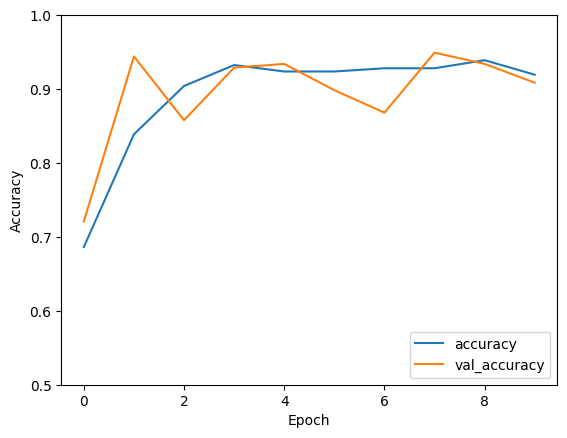

7/7 - 0s - loss: 0.2621 - accuracy: 0.9086 - 63ms/epoch - 9ms/step
0.9086294174194336
[[['House', 85.38815379142761], ['House', 96.87811136245728], ['nothing', 0.57060695], ['Tree', 97.06124067306519]], [['nothing', 0.5244264], ['House', 97.54611849784851], ['House', 98.58344197273254], ['Tree', 99.73323345184326]], [['Tree', 97.1484124660492], ['Tree', 81.17518424987793], ['Tree', 98.75826239585876], ['Tree', 97.71977066993713]], [['Tree', 88.69266510009766], ['Tree', 99.80242252349854], ['Tree', 99.52770471572876], ['Tree', 93.77421736717224]]]
houses: 4
trees: 10


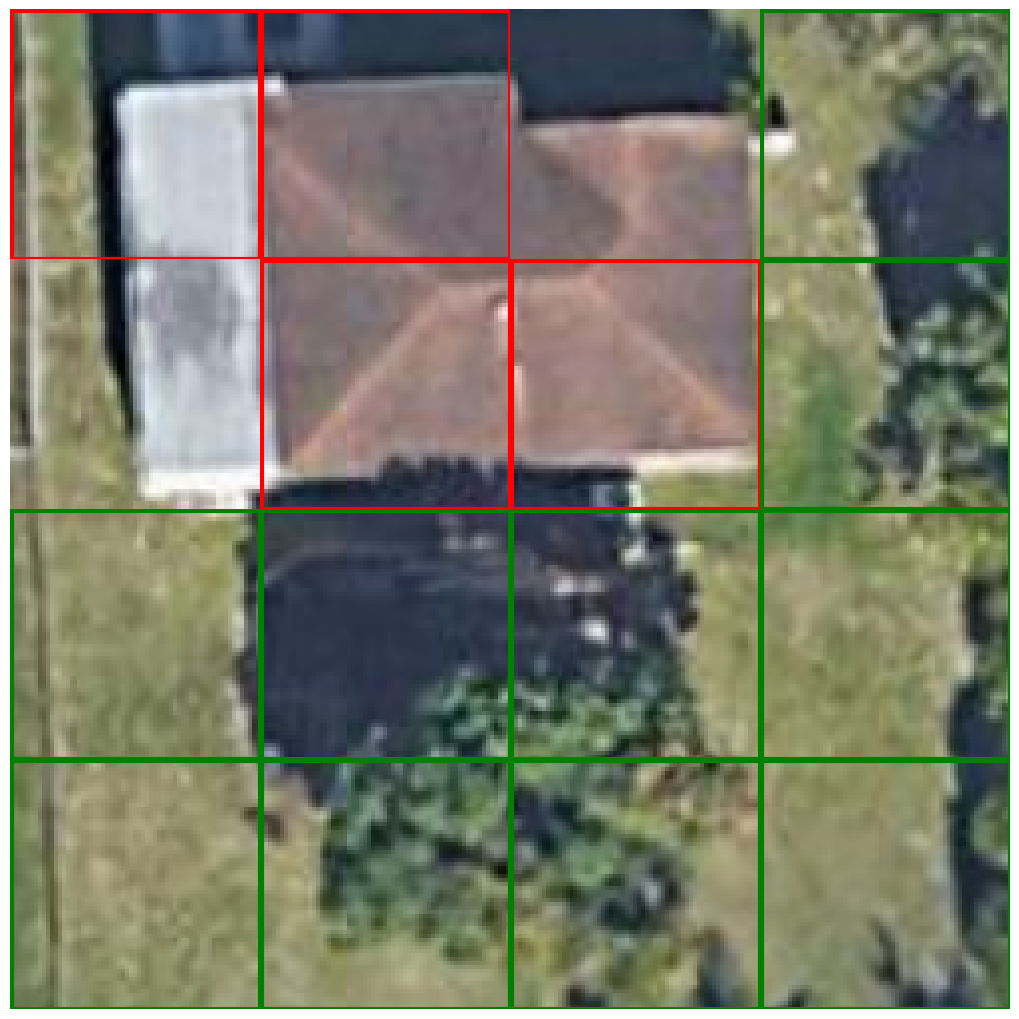

In [7]:
# Plot the models results

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print(test_acc)
# # save the current accuracy results
# plt.savefig("tensorflowAccuracyGraph.png")

# performs object detection on the below image using the newly created model
detect(model, 'Images/2023-03-13_17-53-07.png')
# # saves the current model
# model.save("BST_B10_E10_G1.h5")

[[['House', 94.64370012283325], ['House', 97.93300032615662], ['nothing', 0.79577386], ['Tree', 81.569504737854]], [['House', 93.95644664764404], ['House', 98.65009188652039], ['House', 99.07139539718628], ['Tree', 96.84126377105713]], [['nothing', 0.6238141], ['Tree', 83.74016880989075], ['Tree', 82.31842517852783], ['nothing', 0.58443445]], [['nothing', 0.6780435], ['Tree', 99.57429766654968], ['Tree', 98.72196912765503], ['nothing', 0.63810205]]]
houses: 5
trees: 6


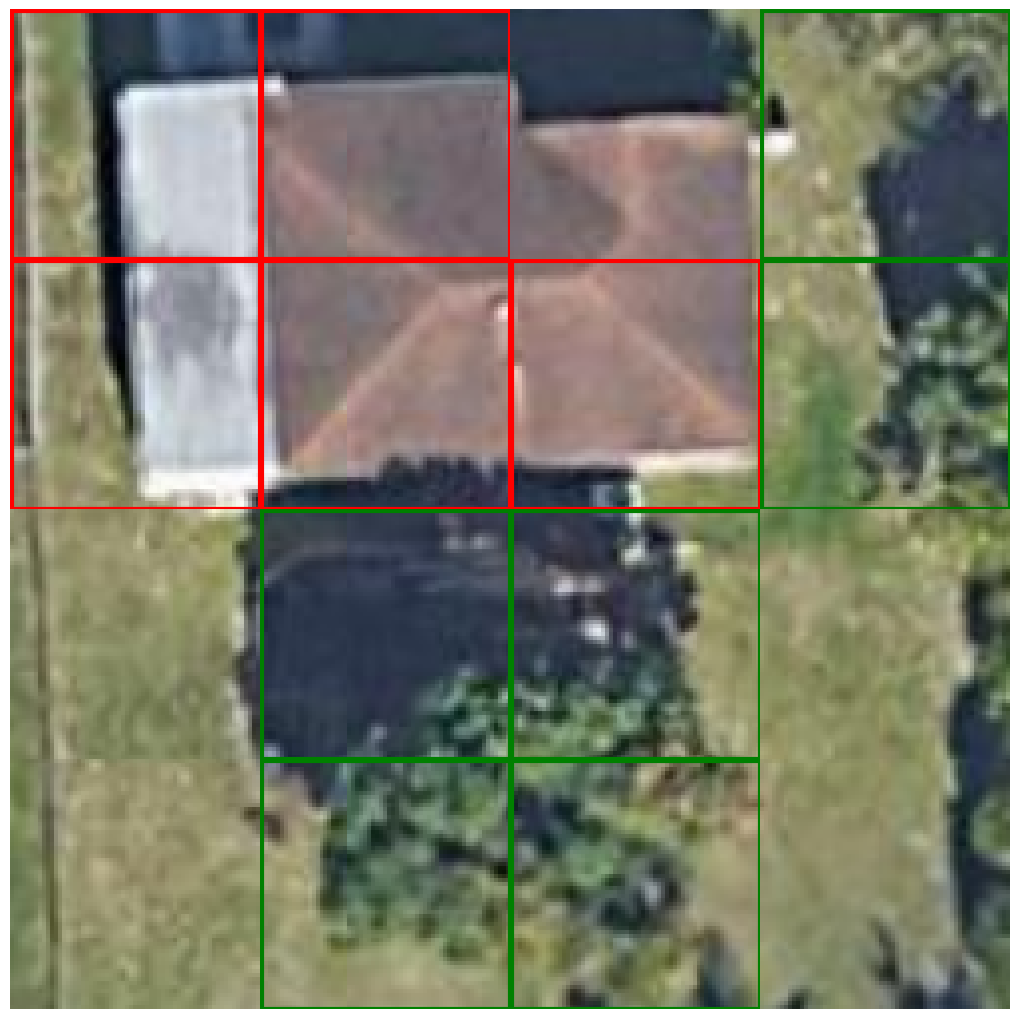

In [8]:
# Object detection
# note this uses a saved model

savedModel = models.load_model('BST_B10_E10_G1.h5')
detect(savedModel, 'Images/2023-03-13_17-53-07.png')

# # save the current resulting image from object detection
# plt.savefig("tensorflowObjectDetection.png")

Epoch 1/10
46/46 [==============================] - 3s 16ms/step - loss: 0.6862 - accuracy: 0.6231 - val_loss: 0.6745 - val_accuracy: 0.7208
Epoch 2/10
46/46 [==============================] - 1s 12ms/step - loss: 0.6618 - accuracy: 0.7015 - val_loss: 0.6474 - val_accuracy: 0.7208
Epoch 3/10
46/46 [==============================] - 1s 12ms/step - loss: 0.6019 - accuracy: 0.7386 - val_loss: 0.5345 - val_accuracy: 0.7919
Epoch 4/10
46/46 [==============================] - 0s 10ms/step - loss: 0.4390 - accuracy: 0.8954 - val_loss: 0.3212 - val_accuracy: 0.8883
Epoch 5/10
46/46 [==============================] - 1s 11ms/step - loss: 0.2684 - accuracy: 0.9150 - val_loss: 0.2281 - val_accuracy: 0.8934
Epoch 6/10
46/46 [==============================] - 1s 15ms/step - loss: 0.1907 - accuracy: 0.9325 - val_loss: 0.1586 - val_accuracy: 0.9391
Epoch 7/10
46/46 [==============================] - 1s 15ms/step - loss: 0.1830 - accuracy: 0.9346 - val_loss: 0.1540 - val_accuracy: 0.9391
Epoch 8/10
46

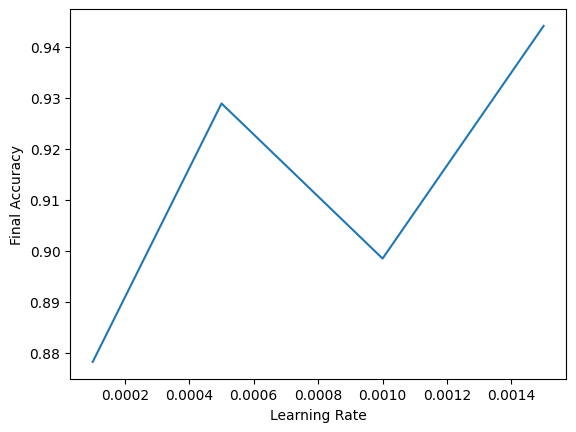

In [5]:
# evaluation of learning rate
learning_rates = [.0001, .0005, .001, .0015]

accuracy_graph = []

for lr in learning_rates:
    model = models.Sequential()
    model.add(layers.RandomFlip("horizontal_and_vertical"))
    model.add(layers.RandomRotation(0.5))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(2))
    # Train the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=True),
                metrics=['accuracy'])

    history = model.fit(train_images, train_labels, epochs=10, batch_size=10,
                        validation_data=(test_images, test_labels))

    test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

    accuracy_graph.append(test_acc)


plt.plot(learning_rates, accuracy_graph, label='accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Final Accuracy')
plt.savefig("tensorflowLearningRateGraph.png")
plt.show()